In [1]:
%load_ext autoreload
%autoreload 2

import os,sys
import h5py  
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu

yu.flag_fast=False
yu.slName='plots_notes_NST_allRatios'

tensorQ=True

In [3]:
ensLs=['24','48']
ensLs=['48']
L2ens={'24':'cA211.530.24','48':'cA2.09.48'}

ensembles=[L2ens[ensL] for ensL in ensLs]

ens2data={}
for ens in ensembles:
    if tensorQ:
        path={
            'cA211.530.24':'/p/project/pines/li47/code/projectData/NST_d-tensor/data/NST_d_cA211.530.24_tensor.h5',
            'cA2.09.48':'/p/project/pines/li47/code/projectData/NST_d-tensor/data/NST_d_cA2.09.48_tensor.h5',
            }[ens]
        yu.gjList=['id','gx','gy','gz','gt','g5','g5gx','g5gy','g5gz','g5gt','sgmyz','sgmzx','sgmxy','sgmtx','sgmty','sgmtz']
    else:
        path={
            'cA211.530.24':'/p/project/pines/li47/code/projectData/NST_d-tensor/data/NST_a_cA211.530.24.h5',
            'cA2.09.48':'/p/project/pines/li47/code/projectData/NST_d-tensor/data/NST_c_cA2.09.48.h5',
            }[ens]
        yu.gjList=['id','gx','gy','gz','gt','g5','g5gx','g5gy','g5gz','g5gt']
    ens2data[ens]=yu.load(path)
    print('Ncfg='+str(yu.deepKey(ens2data[ens]['2pt'],2).shape[0]))
    print()

lat=None
data=None
Ncfg=None
Tpack=None
    
def updateEns(ens):
    global lat,data,Ncfg,Tpack
    lat=yu.LatticeEnsemble(ens)
    data=ens2data[ens]
    Ncfg=yu.deepKey(data['2pt'],2).shape[0]
    Tpack=yu.TPack[ens]
updateEns(ensembles[0])

loading: /p/project/pines/li47/code/projectData/NST_d-tensor/data/NST_d_cA2.09.48_tensor.h5
521/521: diags/Z3pt-pi0f/srcs/Z3pt.h5_NJNpi-c-Nsrc4*1-tensor                            
Ncfg=1228



In [4]:
flags={
    'cc2pt':True, # average quantities related by complex conjugation for 2pt
    'cc3pt':True, # same for 3pt (Removal of vacuum expectation value requires 'cc2pt'=='cc3pt')
    'll2pt':True, # average irrep rows 'l1' and conjugated 'l2' (Parity breaking effect of tmQCD has been taken care of)
    'll3pt':True, # same for 3pt (This flag has no effect if 'll2pt'=True and spin-projection is done)
    'r2pt': True, # making 2ptMat real for the rest frame # 'll2pt' has to be real for this flag
    'remove_pi0VEV':True, 
}

def get2pt(opa,opb,diags=yu.diags_all):
    if opa.split(';')[-1]=='12':
        opa1=';'.join(opa.split(';')[:-1]+['n,pi+']); opa2=';'.join(opa.split(';')[:-1]+['p,pi0'])
        return np.sqrt(2/3)*get2pt(opa1,opb,diags)-np.sqrt(1/3)*get2pt(opa2,opb,diags)
    if opb.split(';')[-1]=='12':
        opb1=';'.join(opb.split(';')[:-1]+['n,pi+']); opb2=';'.join(opb.split(';')[:-1]+['p,pi0'])
        return np.sqrt(2/3)*get2pt(opa,opb1,diags)-np.sqrt(1/3)*get2pt(opa,opb2,diags)
    res=np.zeros([Ncfg,Tpack],dtype=complex)
    if opa+'_'+opb in data['2pt']:
        t=data['2pt'][opa+'_'+opb]
        res+=np.sum([t[diag] for diag in t.keys() if diag in diags],axis=0)
    if opb+'_'+opa in data['2pt']:
        t=data['2pt'][opb+'_'+opa]; 
        diags_cc={'T', 'T-pi0f'}; 
        res+=np.conj(np.sum([t[diag] for diag in t.keys() if diag in diags_cc and diag in diags],axis=0))
    return res
def get2ptMat(ops,diags=yu.diags_all):
    if flags['ll2pt']:
        flags['ll2pt']=False
        ops_flip=[yu.op_flipl(op) for op in ops]
        t=(get2ptMat(ops,diags=diags)+np.conj(get2ptMat(ops_flip,diags=diags)))/2
        flags['ll2pt']=True
        if ops[0].split(';')[1]=='0,0,0' and flags['r2pt']:
            t=np.real(t)
        return t
    t=np.transpose([[get2pt(opa,opb,diags) for opb in ops] for opa in ops],[2,3,0,1])
    if flags['cc2pt']:
        t=(t+np.conj(np.transpose(t,[0,1,3,2])))/2
    return t

def get3pt(opa,opb,insert,diags=yu.diags_all):
    if opa.split(';')[-1]=='12':
        opa1=';'.join(opa.split(';')[:-1]+['n,pi+']); opa2=';'.join(opa.split(';')[:-1]+['p,pi0'])
        return np.sqrt(2/3)*get3pt(opa1,opb,insert,diags)-np.sqrt(1/3)*get3pt(opa2,opb,insert,diags)
    if opb.split(';')[-1]=='12':
        opb1=';'.join(opb.split(';')[:-1]+['n,pi+']); opb2=';'.join(opb.split(';')[:-1]+['p,pi0'])
        return np.sqrt(2/3)*get3pt(opa,opb1,insert,diags)-np.sqrt(1/3)*get3pt(opa,opb2,insert,diags)
    res=np.zeros([Ncfg,int(insert.split('_')[-1])+1],dtype=complex)
    if opa+'_'+opb in data['3pt']:
        t=data['3pt'][opa+'_'+opb][insert]
        res+=np.sum([t[diag] for diag in t.keys() if diag in diags],axis=0)
    if opb+'_'+opa in data['3pt']:
        t=data['3pt'][opb+'_'+opa][insert]; 
        diags_cc={'B3pt','W3pt','Z3pt','T-j', 'T-pi0f-j','T-jPf','B3pt-pi0f','W3pt-pi0f','Z3pt-pi0f'}
        if opa+'_'+opb not in data['3pt'] or 'NJN-pi0f' not in data['3pt'][opa+'_'+opb][insert]:
            diags_cc.add('NJN-pi0i')
        t_add=np.zeros([Ncfg,int(insert.split('_')[-1])+1],dtype=complex)+np.sum([t[diag] for diag in t.keys() if diag in diags_cc and diag in diags],axis=0)
        res+=np.conj(t_add[:,::-1])*(yu.gtCj[insert.split('_')[0]])
    return res
def get3ptMat(opas,opbs,insert,diags=yu.diags_all):
    if flags['ll3pt']:
        flags['ll3pt']=False
        opas_flip=[yu.op_flipl(op) for op in opas]; opbs_flip=[yu.op_flipl(op) for op in opbs]
        sgns=np.array([[yu.op_getl_sgn(opa)*yu.op_getl_sgn(opb) for opb in opbs] for opa in opas])
        sgns*=yu.fourCPTstar[insert.split('_')[0]]
        t=(get3ptMat(opas,opbs,insert,diags=diags)+np.conj(get3ptMat(opas_flip,opbs_flip,insert,diags=diags))*sgns[None,None,:,:])/2
        flags['ll3pt']=True
        return t
    t=np.transpose([[get3pt(opa,opb,insert,diags) for opb in opbs] for opa in opas],[2,3,0,1])
    if flags['cc3pt']:
        flags['cc3pt']=False
        tt=get3ptMat(opbs,opas,insert,diags)[:,::-1]*(yu.gtCj[insert.split('_')[0]])
        flags['cc3pt']=True
        t=(t+np.conj(np.transpose(tt,[0,1,3,2])))/2
    return t

def remove_pi0VEV(Ctij,pi0VEV,opas,opbs):
    if not flags['remove_pi0VEV']:
        return Ctij
    
    factor=yu.coeff['g;0,0,1;G1;N1pi0,a;l1;N,pi'][0][1]
    
    ka=None # index for N(n)pi0(0)
    for i,op in enumerate(opas):
        if yu.getNpar(op)==1:
            qa=i # index for N(n)
            continue
        g,pt,irrep,occ,l,fla=op.split(';')
        if 'pi0' in occ:
            ka=i
            factor_a = factor * {'n,pi+':0,'p,pi0':1,'12':-np.sqrt(1/3)}[fla] * {'l1':1,'l2':-1}[l] * pi0VEV
    kb=None
    for i,op in enumerate(opbs):
        if yu.getNpar(op)==1:
            qb=i
            continue
        g,pt,irrep,occ,l,fla=op.split(';')
        if 'pi0' in occ:
            kb=i
            factor_b = factor * {'n,pi+':0,'p,pi0':1,'12':-np.sqrt(1/3)}[fla] * {'l1':1,'l2':-1}[l] * pi0VEV
            
    res=Ctij.copy()
    if ka is not None:
        res[:,ka,:]-=factor_a*Ctij[:,qa,:]
    if kb is not None:
        res[:,:,kb]-=np.conj(factor_b)*Ctij[:,:,qb]
    if ka is not None and kb is not None:
        res[:,ka,kb]+=factor_a*np.conj(factor_b)*Ctij[:,qa,qb]
        
    return res

pt0='0,0,0'; ofs0=[('a','p'),('N1pi1,a','12'),]; ops0=yu.getops(pt0,'l1',ofs0)
pt1='0,0,1'; ofs1=[('a','p'),('N1pi0,a','12'),('N0pi1,a','12'),]; ops1=yu.getops(pt1,'l1',ofs1)

L2T_ens={'24':'cA211.530.24','48':'cA2.09.48'}

L2ops={'0':ops0,'1':ops1}
L2ptofs={'0':(pt0,ofs0),'1':(pt1,ofs1)}
L2T_pt={'0':r'$\vec{p}=(0,0,0)$','1':r'$\vec{p}=(0,0,1)$'}

L2diags={'noj':yu.diags_jLoopless,'all':yu.diags_all}
L2T_diags={'noj':'no j-loop','all':'all diags'}
diagsLs=['noj','all']

dict_keys(['pi0_conn', 'pi0_disc', 'piC'])


<ErrorbarContainer object of 3 artists>

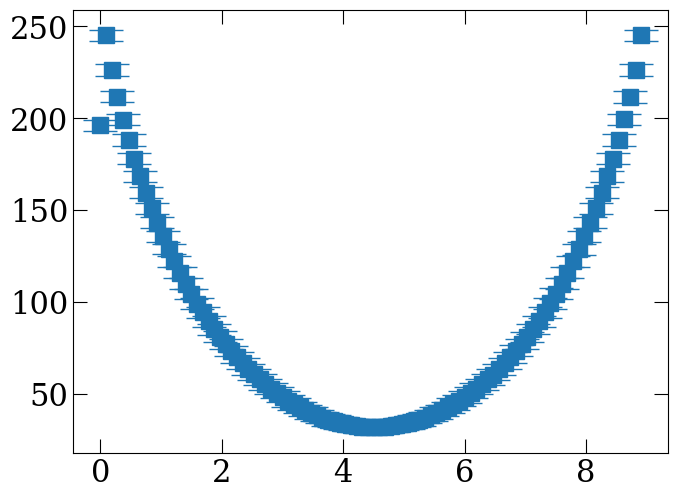

In [5]:
path='/p/project/pines/li47/code/projectData/NST_d-tensor/data/NST_d_cA2.09.48_pion2pt.h5'
datpi={}
with h5py.File(path) as f:
    for key in f['data'].keys():
        datpi[key]=f['data'][key][:]
print(datpi.keys())

#####################################

xUnit=lat.a

mom=0
keys=[['piC'],['pi0_conn'],['pi0_conn','pi0_disc']][2]

vevQ = (mom==0 and 'pi0_disc' in keys)
t=np.sum([datpi[key] for key in keys],axis=0)
t=t[:,:,mom]
t=[t,data['VEV']['pi0f']]

def func(dat):
    t,tVEV=dat
    t=np.mean(t,axis=0)
    if vevQ:
        t-=np.mean(tVEV)**2
    return np.real(t)
    
mean,err,cov=yu.jackknife(t,func)
tmin=0;tmax=len(mean[0])
tMean=mean[0][tmin:tmax]; tErr=err[0][tmin:tmax]

fig, axs = yu.getFigAxs(1,1)
irow=icol=0
axs[irow,icol].errorbar(np.arange(tmin,tmax)*xUnit,tMean,tErr)

